<a href="https://colab.research.google.com/github/Codewiz19/WWT_Team_CTRL-Z-Mandal-/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (EDA)

**Objective:** To deeply understand the customer, order, and store data to inform the development of a context-aware recommendation engine.

This notebook will guide you through:
1.  **Setup & Data Loading:** Connecting to your data in Google Drive.
2.  **Data Cleaning & Preprocessing:** Handling JSON data, normalizing item names, and merging datasets.
3.  **Exploratory Data Analysis (EDA):** Analyzing distributions and relationships within the data.
4.  **Feature Engineering:** Creating powerful new features for context and personalization.
5.  **Contextual Analysis:** Validating the hypothesis that customer behavior changes based on context (e.g., Customer Type, Order Occasion).

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Mount Google Drive
# This will prompt you for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


**Instructions:**
1.  Create a folder named `WWT_Hackathon_2025` in your Google Drive.
2.  Place the four data files (`order_data.csv`, `customer_data.csv`, `store_data.csv`, `test_data_question.csv`) inside this folder.
3.  Update the `file_path` variable below if your folder structure is different.

In [3]:
# Define the path to your data files
file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/'


order_df = pd.read_csv(file_path + 'order_data.csv')
customer_df = pd.read_csv(file_path + 'customer_data.csv')
store_df = pd.read_csv(file_path + 'store_data.csv')
test_df = pd.read_csv(file_path + 'test_data_question.csv')
print('✓ All datasets loaded successfully!')


✓ All datasets loaded successfully!


### Initial Data Inspection

In [4]:
print('--- Order Data ---')
print(order_df.info())
display(order_df.head())

print('\n--- Customer Data ---')
print(customer_df.info())
display(customer_df.head())

print('\n--- Store Data ---')
print(store_df.info())
display(store_df.head())

--- Order Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   CUSTOMER_ID            1048575 non-null  int64 
 1   STORE_NUMBER           1048575 non-null  int64 
 2   ORDER_CREATED_DATE     1048575 non-null  object
 3   ORDER_ID               1048575 non-null  int64 
 4   ORDERS                 1048575 non-null  object
 5   ORDER_CHANNEL_NAME     1048575 non-null  object
 6   ORDER_SUBCHANNEL_NAME  1048575 non-null  object
 7   ORDER_OCCASION_NAME    1048575 non-null  object
dtypes: int64(3), object(5)
memory usage: 64.0+ MB
None


,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME
0,362204699,2156,24-07-2024,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo
1,269612955,1419,15-02-2025,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo
2,585330633,2249,15-02-2025,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo
3,950661333,2513,29-03-2024,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo
4,434985772,1754,08-04-2024,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo



--- Customer Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563346 entries, 0 to 563345
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   CUSTOMER_ID    563346 non-null  int64 
 1   CUSTOMER_TYPE  563319 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.6+ MB
None


,CUSTOMER_ID,CUSTOMER_TYPE
0,362204699,Registered
1,269612955,Registered
2,585330633,Guest
3,950661333,Registered
4,434985772,Guest



--- Store Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   STORE_NUMBER  38 non-null     int64 
 1   CITY          25 non-null     object
 2   STATE         24 non-null     object
 3   POSTAL_CODE   36 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.3+ KB
None


,STORE_NUMBER,CITY,STATE,POSTAL_CODE
0,2156,GRAPEVINE,TX,76051
1,1419,HUNTERSVILLE,NC,28078
2,2249,NaN,NaN,32792
3,2513,LAS VEGAS,NV,89129
4,1754,ARDMORE,OK,73401


## 2. Data Cleaning & Preprocessing

### 2.1 Parsing the 'ORDERS' JSON Column

The `ORDERS` column is a JSON string. We need to parse it to extract individual items from each order. This process is called "flattening" or "exploding" the data.

In [5]:
def parse_orders(df):
    """Parses the JSON 'ORDERS' column and flattens the DataFrame."""
    all_orders = []

    for index, row in df.iterrows():
        try:
            # Load the JSON string from the 'ORDERS' column
            order_data = json.loads(row['ORDERS'])

            # The item details are nested within 'orders' and 'item_details' keys
            for order_group in order_data.get('orders', []):
                for item in order_group.get('item_details', []):
                    # Create a dictionary for each item, including the original row's info
                    flat_item = {
                        'CUSTOMER_ID': row['CUSTOMER_ID'],
                        'STORE_NUMBER': row['STORE_NUMBER'],
                        'ORDER_CREATED_DATE': row['ORDER_CREATED_DATE'],
                        'ORDER_ID': row['ORDER_ID'],
                        'ORDER_CHANNEL_NAME': row['ORDER_CHANNEL_NAME'],
                        'ORDER_SUBCHANNEL_NAME': row['ORDER_SUBCHANNEL_NAME'],
                        'ORDER_OCCASION_NAME': row['ORDER_OCCASION_NAME'],
                        'item_name': item.get('item_name'),
                        'item_price': item.get('item_price'),
                        'item_quantity': item.get('item_quantity')
                    }
                    all_orders.append(flat_item)
        except (json.JSONDecodeError, TypeError):
            # Handle cases where 'ORDERS' might be malformed or not a string
            continue

    return pd.DataFrame(all_orders)

# Apply the function to the order_df
print('Parsing ORDERS column... This may take a moment.')
df_flat = parse_orders(order_df)
print('✓ Parsing complete.')
display(df_flat.head())

Parsing ORDERS column... This may take a moment.
✓ Parsing complete.


,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,item_name,item_price,item_quantity
0,362204699,2156,24-07-2024,7247194287,Digital,WWT,ToGo,Order Memo Not Paid,0.00,1
1,362204699,2156,24-07-2024,7247194287,Digital,WWT,ToGo,10 pc Grilled Wings Combo,15.29,1
2,362204699,2156,24-07-2024,7247194287,Digital,WWT,ToGo,8 pc Grilled Wings Combo,13.29,1
3,362204699,2156,24-07-2024,7247194287,Digital,WWT,ToGo,8 pc Spicy Wings Combo,10.99,1
4,269612955,1419,15-02-2025,791214421,Digital,WWT,ToGo,Ranch Dip - Regular,1.59,1


### 2.2 Item Name Cleaning & Normalization

Real-world data is messy. We need to clean up the item names to ensure consistency. This involves:
1.  Removing non-product entries (like 'Order Memo').
2.  Standardizing names (e.g., '6pc' vs '6 pc').

In [6]:
# First, let's see all the unique item names we're dealing with
unique_items = df_flat['item_name'].unique()
print(f'Found {len(unique_items)} unique item names.')

# Let's identify items that are likely not actual products
non_product_keywords = ['memo', 'blankline', 'asap', 'paid', 'not paid', 'tax', 'fee']
non_product_items = [item for item in unique_items if any(keyword in str(item).lower() for keyword in non_product_keywords)]

print('\n--- Potential Non-Product Items to Remove ---')
for item in sorted(non_product_items):
    print(item)

Found 142 unique item names.

--- Potential Non-Product Items to Remove ---
Delivery Fee
Order Blankline 1
Order Blankline 2
Order Memo ASAP
Order Memo Future
Order Memo Item
Order Memo Not Paid
Order Memo Paid


In [7]:
# Filter out the non-product items
print(f'Original number of rows: {len(df_flat)}')
df_cleaned = df_flat[~df_flat['item_name'].str.lower().str.contains('|'.join(non_product_keywords), na=False)].copy()
print(f'Number of rows after removing non-products: {len(df_cleaned)}')

# Also filter out items with a price of 0, as they are likely not real products
df_cleaned = df_cleaned[df_cleaned['item_price'] > 0].copy()
print(f'Number of rows after removing zero-price items: {len(df_cleaned)}')

# Let's inspect the remaining unique item names
print('\n--- Remaining Unique Item Names (Sample) ---')
for item in sorted(df_cleaned['item_name'].unique())[:20]:
    print(item)

Original number of rows: 4180341
Number of rows after removing non-products: 2084311
Number of rows after removing zero-price items: 2078233

--- Remaining Unique Item Names (Sample) ---
$19.99 Crispy Feast
10 pc Grilled Wings
10 pc Grilled Wings Combo
10 pc Mixed Wings
10 pc Mixed Wings Combo
10 pc Spicy Wings
10 pc Spicy Wings Combo
100 pc Family Grilled Wings
100 pc Family Mixed Wings
100 pc Family Spicy Wings
100 pc Grilled Wings
100 pc Mixed Wings
100 pc Spicy Wings
15 pc Crispy Strips
15 pc Grilled Wings
15 pc Grilled Wings Combo
15 pc Mixed Wings
15 pc Mixed Wings Combo
15 pc Spicy Wings
15 pc Spicy Wings Combo


In [8]:
# For now, let's create a 'base_item' column that you can refine.
# This simple version just copies the item_name.
df_cleaned['base_item'] = df_cleaned['item_name']

### 2.3 Merging Datasets to Create an Analytical Base Table (ABT)

In [20]:
# Merge with customer data
df_merged = pd.merge(df_cleaned, customer_df, on='CUSTOMER_ID', how='left')

# Merge with store data
df_full_context = pd.merge(df_merged, store_df, on='STORE_NUMBER', how='left')

# Handle potential missing values from the joins
df_full_context['CUSTOMER_TYPE'].fillna('Guest', inplace=True) # Assume missing type is Guest
df_full_context['CITY'].fillna('Unknown', inplace=True)
df_full_context['STATE'].fillna('Unknown', inplace=True)
df_full_context['POSTAL_CODE'].fillna('Unknown', inplace=True)

print('✓ Merging complete. Created the Analytical Base Table (ABT).')
display(df_full_context.info())
display(df_full_context.head())

/tmp/ipython-input-1730851200.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_full_context['CUSTOMER_TYPE'].fillna('Guest', inplace=True) # Assume missing type is Guest
/tmp/ipython-input-1730851200.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

✓ Merging complete. Created the Analytical Base Table (ABT).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078233 entries, 0 to 2078232
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   CUSTOMER_ID            int64  
 1   STORE_NUMBER           int64  
 2   ORDER_CREATED_DATE     object 
 3   ORDER_ID               int64  
 4   ORDER_CHANNEL_NAME     object 
 5   ORDER_SUBCHANNEL_NAME  object 
 6   ORDER_OCCASION_NAME    object 
 7   item_name              object 
 8   item_price             float64
 9   item_quantity          int64  
 10  base_item              object 
 11  CUSTOMER_TYPE          object 
 12  CITY                   object 
 13  STATE                  object 
 14  POSTAL_CODE            object 
dtypes: float64(1), int64(4), object(10)
memory usage: 237.8+ MB


None

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,item_name,item_price,item_quantity,base_item,CUSTOMER_TYPE,CITY,STATE,POSTAL_CODE
0,362204699,2156,24-07-2024,7247194287,Digital,WWT,ToGo,10 pc Grilled Wings Combo,15.29,1,10 pc Grilled Wings Combo,Registered,GRAPEVINE,TX,76051
1,362204699,2156,24-07-2024,7247194287,Digital,WWT,ToGo,8 pc Grilled Wings Combo,13.29,1,8 pc Grilled Wings Combo,Registered,GRAPEVINE,TX,76051
2,362204699,2156,24-07-2024,7247194287,Digital,WWT,ToGo,8 pc Spicy Wings Combo,10.99,1,8 pc Spicy Wings Combo,Registered,GRAPEVINE,TX,76051
3,269612955,1419,15-02-2025,791214421,Digital,WWT,ToGo,Ranch Dip - Regular,1.59,1,Ranch Dip - Regular,Registered,HUNTERSVILLE,NC,28078
4,269612955,1419,15-02-2025,791214421,Digital,WWT,ToGo,50 pc Grilled Wings,65.49,1,50 pc Grilled Wings,Registered,HUNTERSVILLE,NC,28078


from matplotlib import pyplot as plt
_df_0['CUSTOMER_ID'].plot(kind='hist', bins=20, title='CUSTOMER_ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['STORE_NUMBER'].plot(kind='hist', bins=20, title='STORE_NUMBER')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['ORDER_ID'].plot(kind='hist', bins=20, title='ORDER_ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['item_price'].plot(kind='hist', bins=20, title='item_price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('ORDER_CREATED_DATE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('item_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('base_item').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('CITY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='CUSTOMER_ID', y='STORE_NUMBER', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='STORE_NUMBER', y='ORDER_ID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='ORDER_ID', y='item_price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ORDER_CREATED_DATE']
  ys = series['CUSTOMER_ID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('ORDER_CREATED_DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ORDER_CREATED_DATE')):
  _plot_series(series, series_name, i)
  fig.legend(title='ORDER_CREATED_DATE', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ORDER_CREATED_DATE')
_ = plt.ylabel('CUSTOMER_ID')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ORDER_CREATED_DATE']
  ys = series['CUSTOMER_ID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('ORDER_CREATED_DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('item_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='item_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ORDER_CREATED_DATE')
_ = plt.ylabel('CUSTOMER_ID')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ORDER_CREATED_DATE']
  ys = series['CUSTOMER_ID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('ORDER_CREATED_DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('base_item')):
  _plot_series(series, series_name, i)
  fig.legend(title='base_item', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ORDER_CREATED_DATE')
_ = plt.ylabel('CUSTOMER_ID')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['ORDER_CREATED_DATE']
  ys = series['CUSTOMER_ID']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('ORDER_CREATED_DATE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('CITY')):
  _plot_series(series, series_name, i)
  fig.legend(title='CITY', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ORDER_CREATED_DATE')
_ = plt.ylabel('CUSTOMER_ID')

from matplotlib import pyplot as plt
_df_15['CUSTOMER_ID'].plot(kind='line', figsize=(8, 4), title='CUSTOMER_ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['STORE_NUMBER'].plot(kind='line', figsize=(8, 4), title='STORE_NUMBER')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['ORDER_ID'].plot(kind='line', figsize=(8, 4), title='ORDER_ID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['item_price'].plot(kind='line', figsize=(8, 4), title='item_price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['item_name'].value_counts()
    for x_label, grp in _df_19.groupby('ORDER_CREATED_DATE')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ORDER_CREATED_DATE')
_ = plt.ylabel('item_name')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['base_item'].value_counts()
    for x_label, grp in _df_20.groupby('item_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('item_name')
_ = plt.ylabel('base_item')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CITY'].value_counts()
    for x_label, grp in _df_21.groupby('base_item')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('base_item')
_ = plt.ylabel('CITY')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['STATE'].value_counts()
    for x_label, grp in _df_22.groupby('CITY')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CITY')
_ = plt.ylabel('STATE')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['ORDER_CREATED_DATE'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='CUSTOMER_ID', y='ORDER_CREATED_DATE', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['item_name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='CUSTOMER_ID', y='item_name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['base_item'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='CUSTOMER_ID', y='base_item', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_26['CITY'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_26, x='CUSTOMER_ID', y='CITY', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

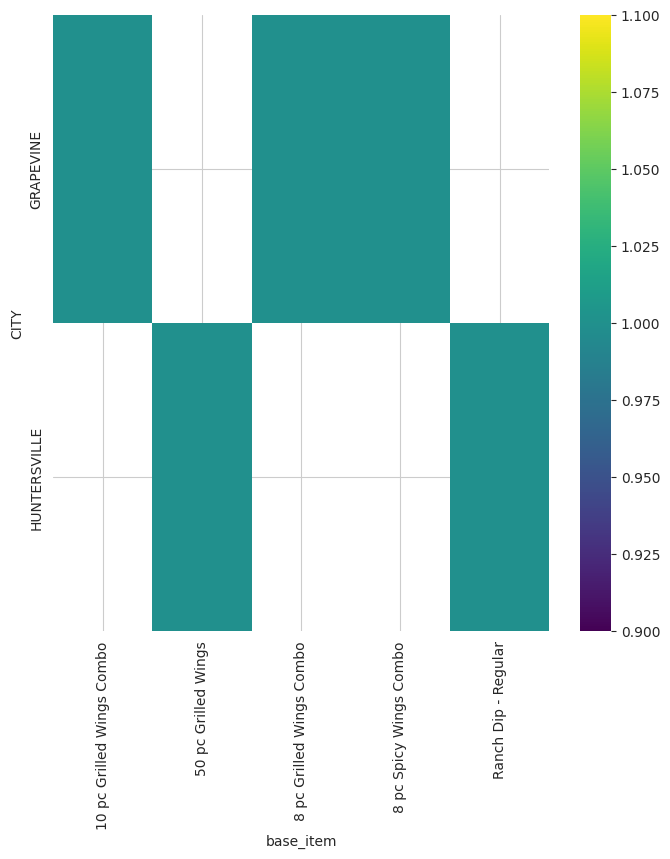

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CITY'].value_counts()
    for x_label, grp in _df_21.groupby('base_item')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('base_item')
_ = plt.ylabel('CITY')

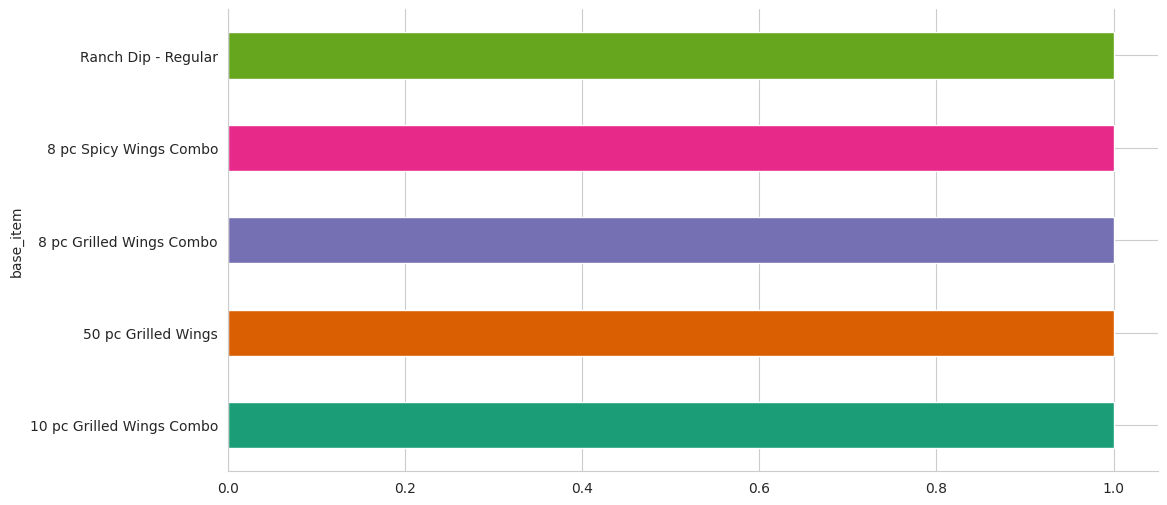

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('base_item').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

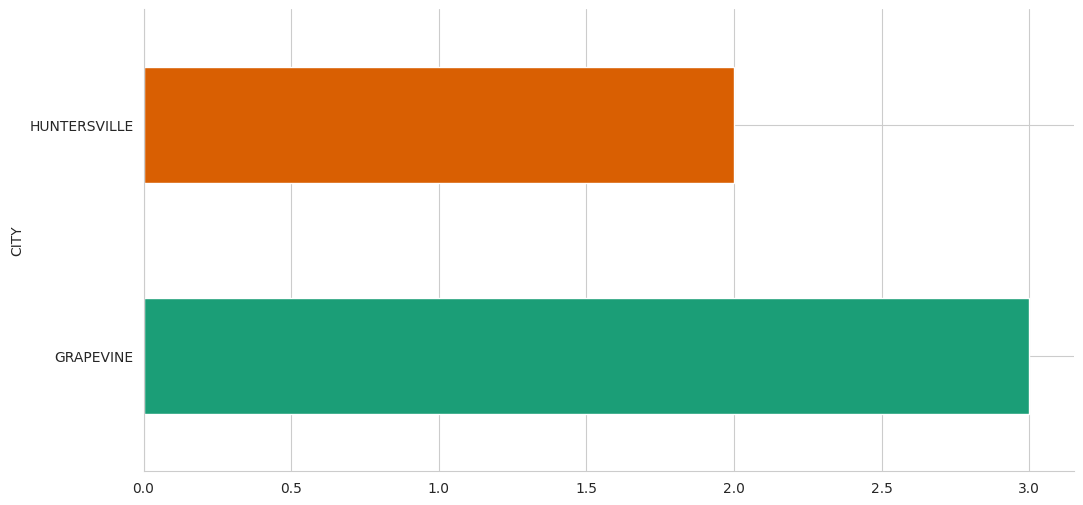

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('CITY').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## 3. Exploratory Data Analysis (EDA)

In [10]:
def plot_bar(df, column, title):
    """Helper function to create a bar plot for a categorical column."""
    plt.figure(figsize=(10, 5))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index, palette='viridis')
    plt.title(title, fontsize=16)
    plt.xlabel('Number of Orders/Items')
    plt.ylabel('')
    plt.show()

/tmp/ipython-input-2713388338.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=column, data=df, order=df[column].value_counts().index, palette='viridis')


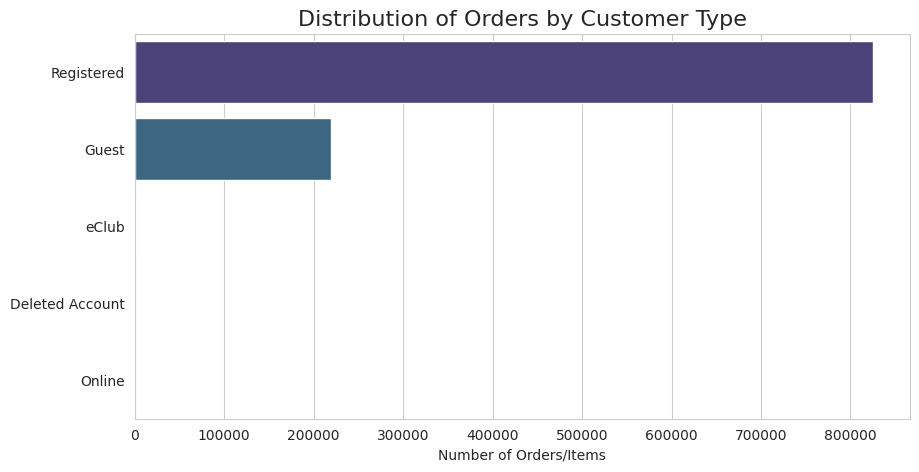

In [11]:
plot_bar(df_full_context.drop_duplicates(subset=['ORDER_ID']), 'CUSTOMER_TYPE', 'Distribution of Orders by Customer Type')

/tmp/ipython-input-2713388338.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=column, data=df, order=df[column].value_counts().index, palette='viridis')


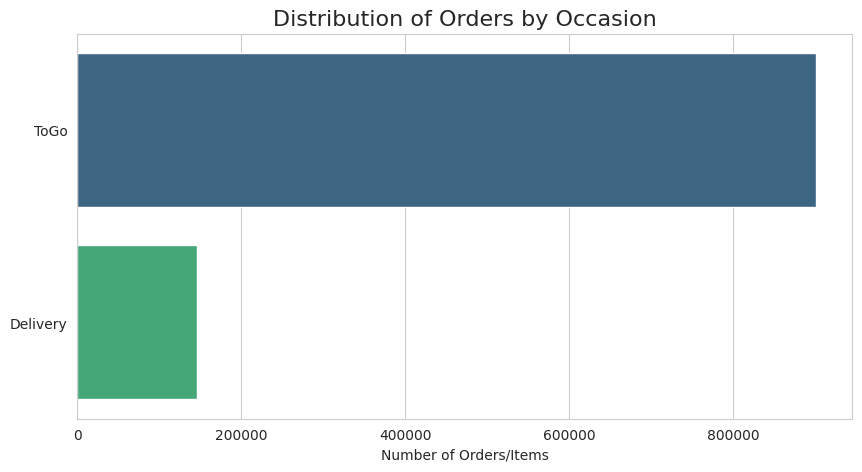

In [12]:
plot_bar(df_full_context.drop_duplicates(subset=['ORDER_ID']), 'ORDER_OCCASION_NAME', 'Distribution of Orders by Occasion')

/tmp/ipython-input-2713388338.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=column, data=df, order=df[column].value_counts().index, palette='viridis')


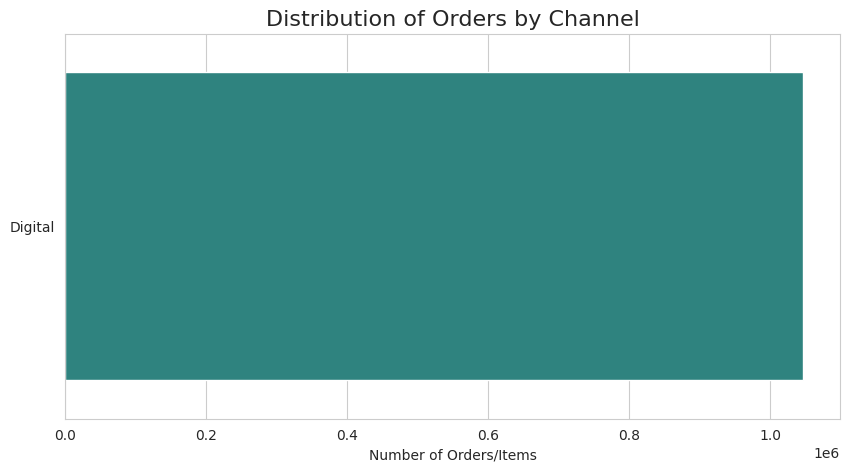

In [13]:
plot_bar(df_full_context.drop_duplicates(subset=['ORDER_ID']), 'ORDER_CHANNEL_NAME', 'Distribution of Orders by Channel')

### Top 20 Most Popular Items

/tmp/ipython-input-868190803.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.values, y=top_items.index, palette='rocket')


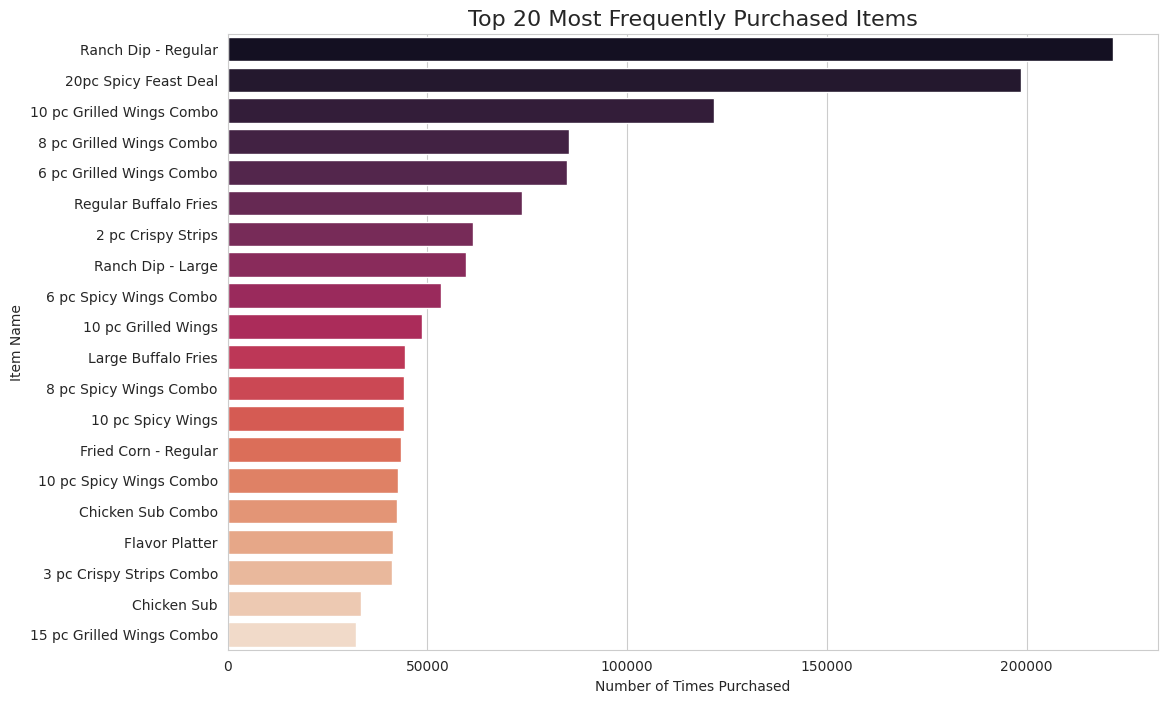

In [14]:
plt.figure(figsize=(12, 8))
top_items = df_full_context['base_item'].value_counts().nlargest(20)
sns.barplot(x=top_items.values, y=top_items.index, palette='rocket')
plt.title('Top 20 Most Frequently Purchased Items', fontsize=16)
plt.xlabel('Number of Times Purchased')
plt.ylabel('Item Name')
plt.show()

## 4. Feature Engineering

### 4.1 Temporal Features

In [15]:
# Convert to datetime
df_full_context['ORDER_CREATED_DATE'] = pd.to_datetime(df_full_context['ORDER_CREATED_DATE'])

# Extract temporal features
df_full_context['DayOfWeek'] = df_full_context['ORDER_CREATED_DATE'].dt.day_name()
df_full_context['IsWeekend'] = df_full_context['ORDER_CREATED_DATE'].dt.weekday >= 5
df_full_context['Month'] = df_full_context['ORDER_CREATED_DATE'].dt.month
df_full_context['Hour'] = df_full_context['ORDER_CREATED_DATE'].dt.hour

# Create Daypart
def get_daypart(hour):
    if 5 <= hour < 11:
        return 'Morning'
    elif 11 <= hour < 16:
        return 'Lunch'
    elif 16 <= hour < 21:
        return 'Dinner'
    else:
        return 'Late Night'

df_full_context['Daypart'] = df_full_context['Hour'].apply(get_daypart)

print('✓ Temporal features created.')
display(df_full_context[['ORDER_CREATED_DATE', 'DayOfWeek', 'IsWeekend', 'Daypart']].head())

/tmp/ipython-input-3108940189.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_full_context['ORDER_CREATED_DATE'] = pd.to_datetime(df_full_context['ORDER_CREATED_DATE'])


✓ Temporal features created.


,ORDER_CREATED_DATE,DayOfWeek,IsWeekend,Daypart
0,2024-07-24,Wednesday,False,Late Night
1,2024-07-24,Wednesday,False,Late Night
2,2024-07-24,Wednesday,False,Late Night
3,2025-02-15,Saturday,True,Late Night
4,2025-02-15,Saturday,True,Late Night


/tmp/ipython-input-2064900843.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_full_context.drop_duplicates(subset=['ORDER_ID']), x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='cubehelix')


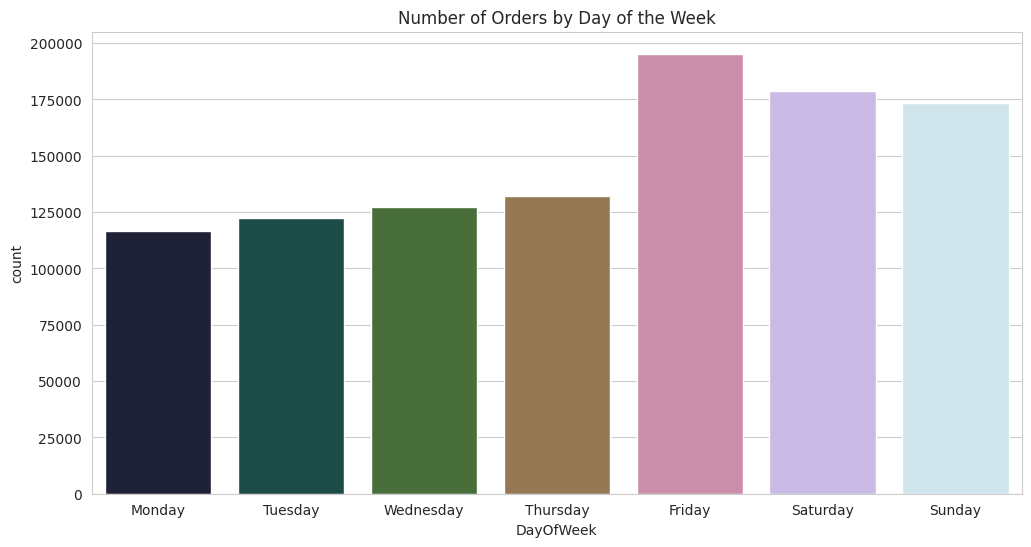

In [16]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_full_context.drop_duplicates(subset=['ORDER_ID']), x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='cubehelix')
plt.title('Number of Orders by Day of the Week')
plt.show()

/tmp/ipython-input-106324938.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_full_context.drop_duplicates(subset=['ORDER_ID']), x='Daypart', order=['Morning', 'Lunch', 'Dinner', 'Late Night'], palette='crest')


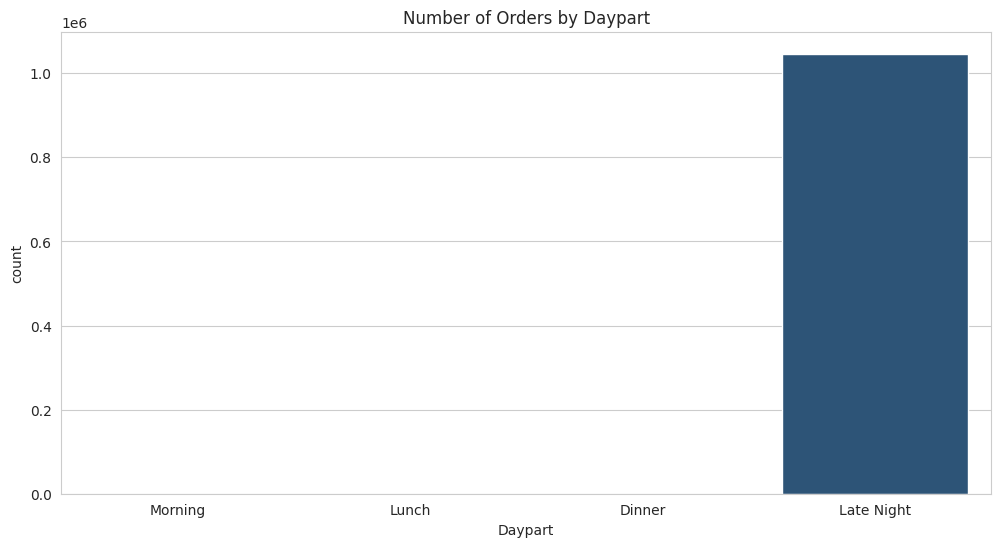

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_full_context.drop_duplicates(subset=['ORDER_ID']), x='Daypart', order=['Morning', 'Lunch', 'Dinner', 'Late Night'], palette='crest')
plt.title('Number of Orders by Daypart')
plt.show()

## 5. Contextual Analysis: The Core of the Strategy

Now, let's validate the core hypothesis: **Does purchasing behavior change based on context?**

We will look at the top items for our four main contexts:
1.  Registered Customers, Delivery
2.  Registered Customers, ToGo
3.  Guest Customers, Delivery
4.  Guest Customers, ToGo

In [18]:
# Rename ORDER_OCCASION_NAME to a shorter name for convenience
df_full_context.rename(columns={'ORDER_OCCASION_NAME': 'ORDER_OCCASION'}, inplace=True)

# Segment the data
df_reg_deliv = df_full_context[(df_full_context['CUSTOMER_TYPE'] == 'Registered') & (df_full_context['ORDER_OCCASION'] == 'Delivery')]
df_reg_togo = df_full_context[(df_full_context['CUSTOMER_TYPE'] == 'Registered') & (df_full_context['ORDER_OCCASION'] == 'ToGo')]
df_guest_deliv = df_full_context[(df_full_context['CUSTOMER_TYPE'] == 'Guest') & (df_full_context['ORDER_OCCASION'] == 'Delivery')]
df_guest_togo = df_full_context[(df_full_context['CUSTOMER_TYPE'] == 'Guest') & (df_full_context['ORDER_OCCASION'] == 'ToGo')]

context_dfs = {
    'Registered - Delivery': df_reg_deliv,
    'Registered - ToGo': df_reg_togo,
    'Guest - Delivery': df_guest_deliv,
    'Guest - ToGo': df_guest_togo
}

/tmp/ipython-input-1023060897.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.values, y=top_items.index, ax=ax, palette='mako')
/tmp/ipython-input-1023060897.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.values, y=top_items.index, ax=ax, palette='mako')
/tmp/ipython-input-1023060897.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.values, y=top_items.index, ax=ax, palette='mako')
/tmp/ipython-input-1023060897.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

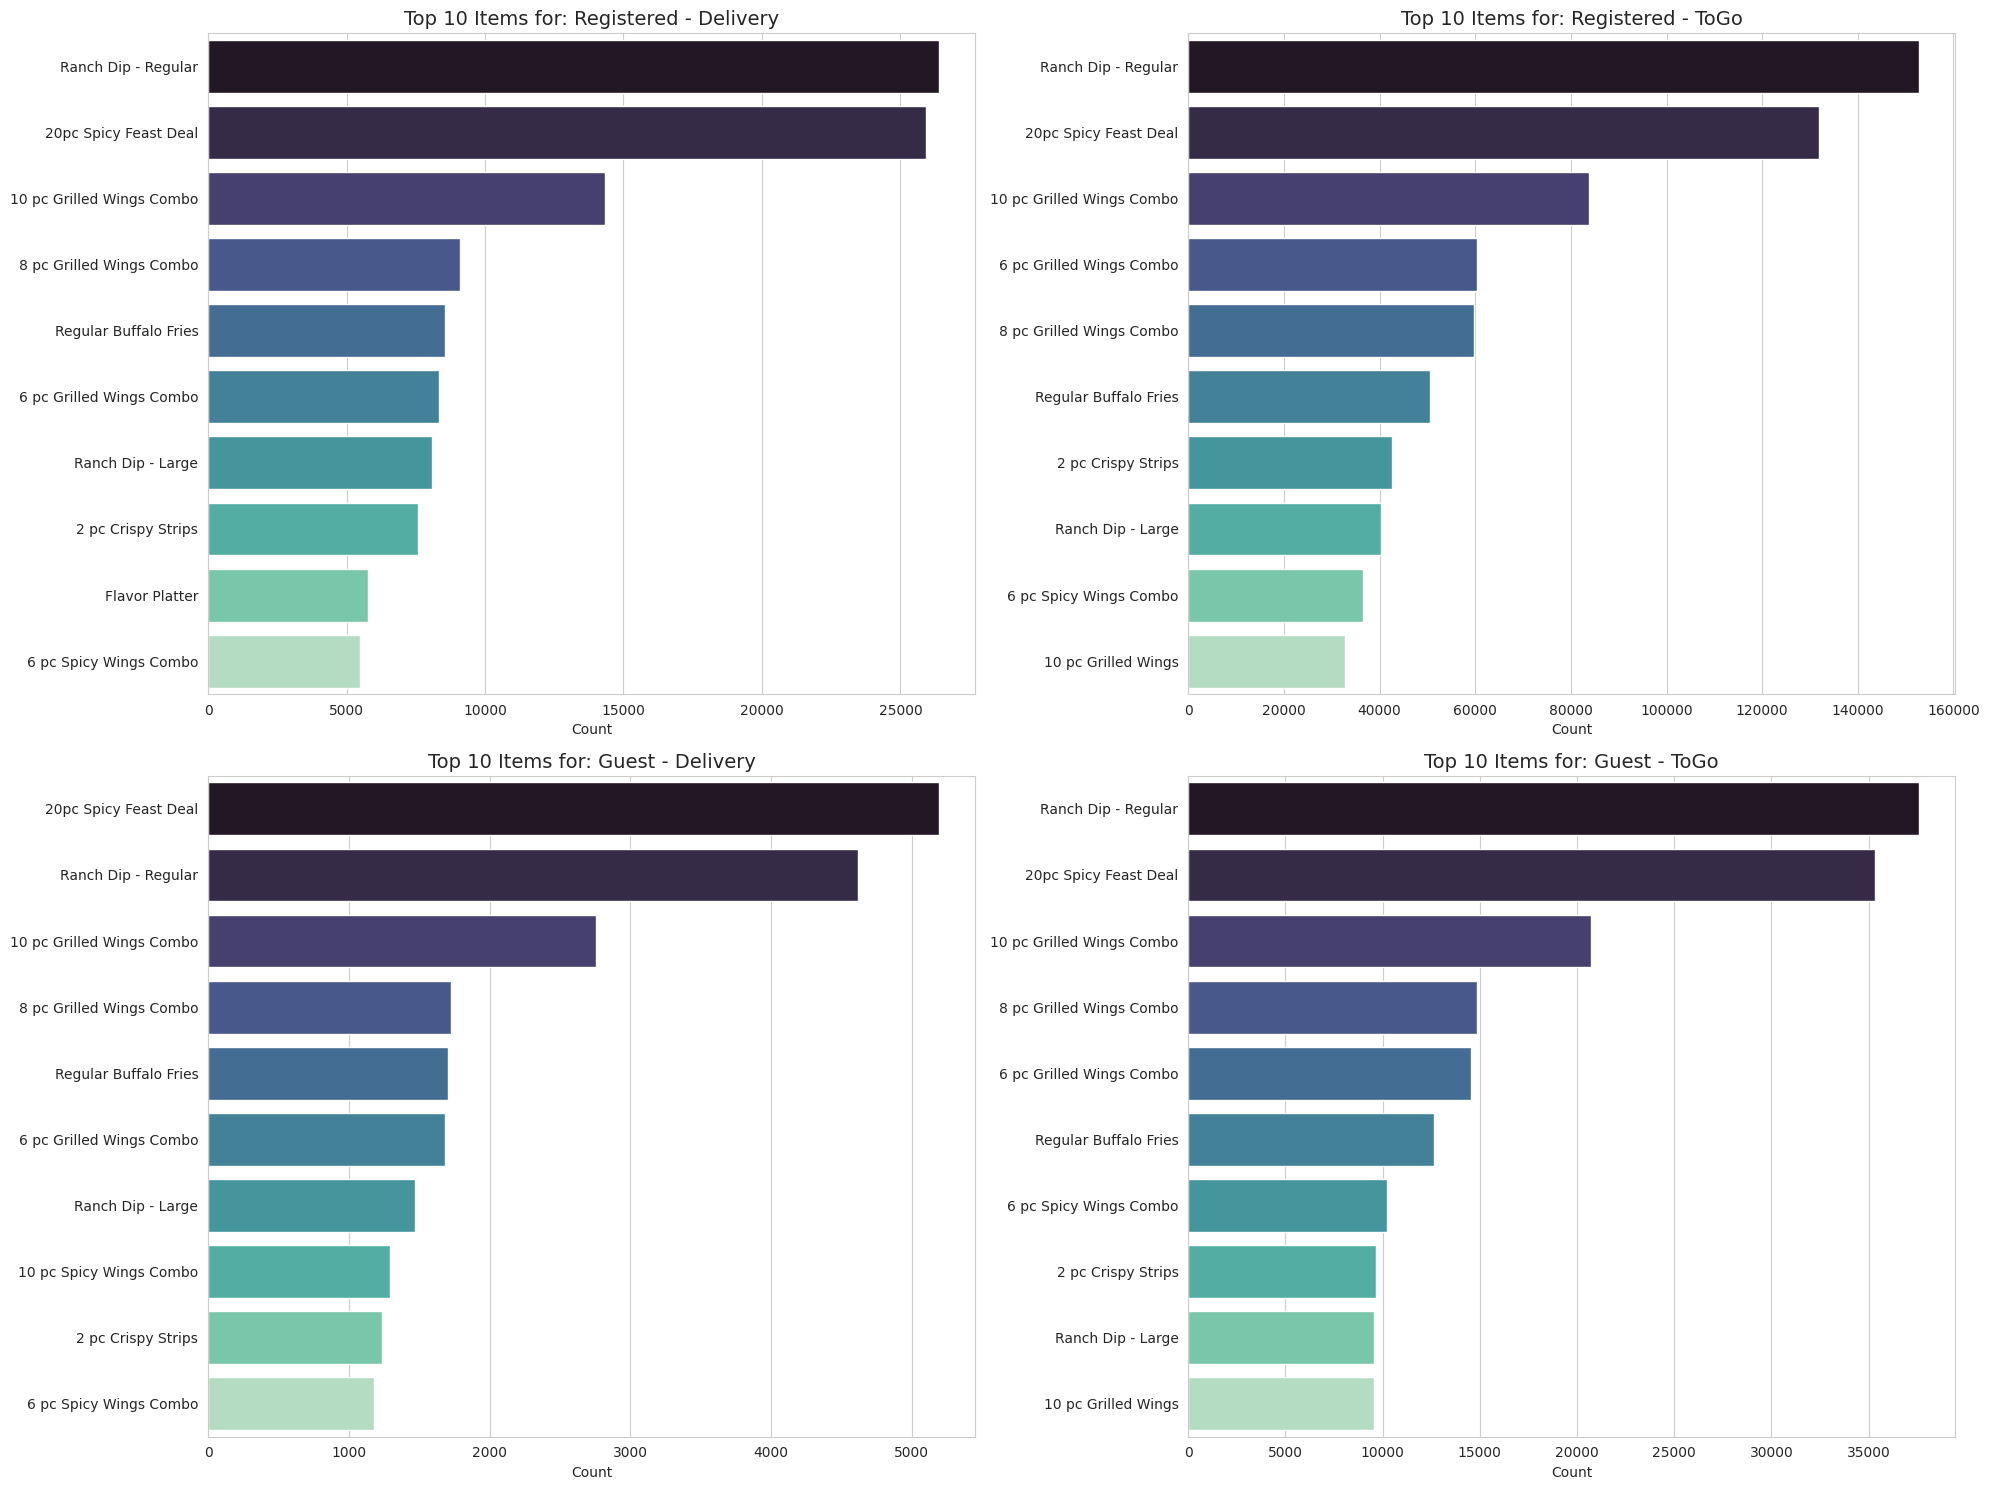

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

for i, (title, df) in enumerate(context_dfs.items()):
    ax = axes[i]
    top_items = df['base_item'].value_counts().nlargest(10)
    sns.barplot(x=top_items.values, y=top_items.index, ax=ax, palette='mako')
    ax.set_title(f'Top 10 Items for: {title}', fontsize=14)
    ax.set_xlabel('Count')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

# Conclusions

Data Requires Aggressive Filtering: The ORDERS column contains significant "junk" data like 'memo' and 'tip' which are not food items. A primary conclusion was the need for a robust filtering system to isolate only actual products for training.

Context is a Goldmine: We concluded that a simple item-to-item model would be insufficient. The data is rich with context like CUSTOMER_TYPE, ORDER_OCCASION_NAME (ToGo/Delivery), and CITY, all of which are crucial for creating nuanced, relevant recommendations.

A Hybrid Model is Essential: The presence of both Registered users (with purchase histories) and anonymous Guest users makes a single recommendation strategy ineffective. We concluded that a hybrid system, combining personalized models for registered users and general models for guests, is non-negotiable.

JSON Parsing is a Key Hurdle: The item data is not in a simple list but is deeply nested within a complex JSON structure ({"orders": [{"item_details": [...]}]}). A key takeaway was the need to build a specific, error-proof parser to reliably extract this information.

Location-Specific Tastes are Likely: The presence of store location data (CITY, STATE) led to the conclusion that customer preferences are not uniform. Incorporating this geographical data is a major opportunity to capture local tastes and make recommendations more relevant.
